In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as T

In [156]:
from paths import *
from utils import *

In [157]:
config = {
    "dataset": "CIFAR10",
    "data_folder": "data",
    "log_folder": "logs",
    "prefix": "CNN-L2",
    "seed": 1234
}

In [158]:
np.random.seed(config['seed'])
torch.manual_seed(config['seed'])
torch.cuda.manual_seed(config['seed'])

In [159]:
feature_names = get_labels( config['dataset'] )
feature_names

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

# Data Augmentation

In [160]:
temp_loader = get_dataLoader(train_data, 5, True)

In [161]:
img, label = next( iter( temp_loader ) )
img.shape, label.shape

(torch.Size([5, 3, 32, 32]), torch.Size([5]))

In [162]:
tf_RandomResizedCrop = T.RandomResizedCrop(32, scale=(0.08, 1.0), ratio=(0.75, 1.3))
tf_RandomRotation = T.RandomRotation((20,60))
tf_ColorJitter = T.ColorJitter(brightness=30, contrast=5, saturation=0, hue=0)

In [163]:
tf_RandomResizedCrop_img = tf_RandomResizedCrop(img)
tf_RandomRotation_img = tf_RandomRotation(img)
tf_ColorJitter_img = tf_ColorJitter(img)

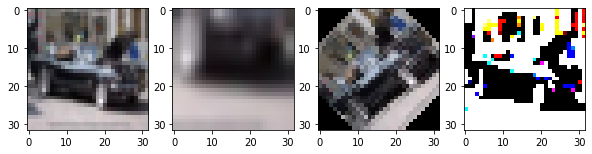

In [167]:
fig, axs = plt.subplots( 1, 4, figsize=(10, 10 *4) )

indx = np.random.randint(0,5)

axs[0].imshow( img[indx].permute(1, 2, 0) )
axs[1].imshow( tf_RandomResizedCrop_img[indx].permute(1, 2, 0) )
axs[2].imshow( tf_RandomRotation_img[indx].permute(1, 2, 0) )
axs[3].imshow(tf_ColorJitter_img[indx].permute(1, 2, 0) )

# Collate_fn

In [168]:
train_full = get_dataset(config['dataset'], train=True)
test_data = get_dataset(config['dataset'], train=False)

len(train_full), len(test_data)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

In [169]:
val_split = int( len(train_full) * 0.15 )

train_split = len(train_full) - val_split
train_data, val_data = split_data(train_full, [train_split, val_split], config['seed'])

In [170]:
def _augmentation(img_size=32):
    return [
        T.RandomResizedCrop(img_size, scale=(0.08, 1.0), ratio=(0.75, 1.3)),
        T.RandomRotation((20,60)),
        T.ColorJitter(brightness=30, contrast=5, saturation=0, hue=0)
    ]

type_augmentation = _augmentation()

In [171]:
def random_augmentation(batch):
    data = torch.stack([ type_augmentation[ np.random.randint(0, len(type_augmentation)-1) ](item[0]) for item in batch ])
    label = torch.tensor([ item[1] for item in batch ])

    return [ data, label ]

In [172]:
train_loader = DataLoader(train_data, batch_size=5)
test_collate = DataLoader(train_data, batch_size=5, collate_fn=random_augmentation)

In [173]:
img_train, label_train = next( iter( train_loader ) )
img_aug, label_aug = next( iter( test_collate ) )

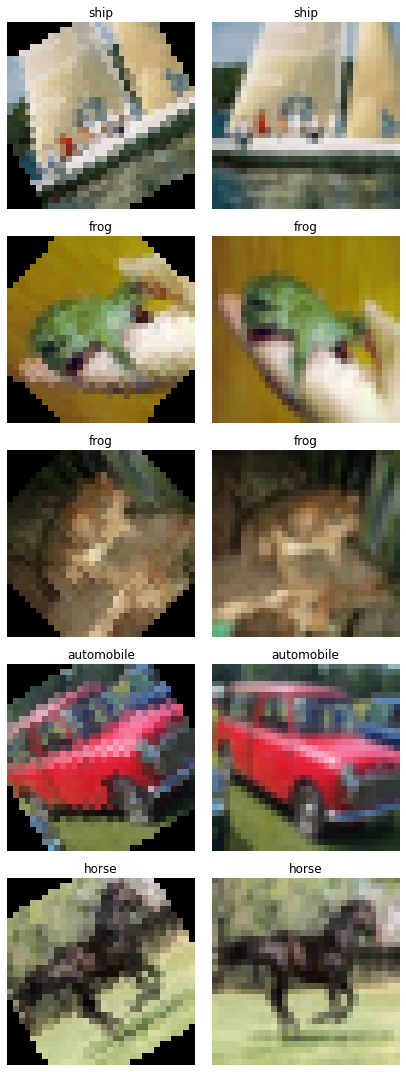

In [175]:
fig, ax = plt.subplots( 5, 2, figsize=(3*2, 3*5 ) )

for i in range(5):
    ax[i, 0].imshow(img_aug[i].permute(1, 2, 0))
    ax[i, 0].set_title( feature_names[ label_aug[i].item() ] )
    ax[i, 0].axis(False)
    
    ax[i, 1].imshow(img_train[i].permute(1, 2, 0))
    ax[i, 1].set_title( feature_names[ label_train[i].item() ] )
    ax[i, 1].axis(False)

plt.tight_layout()
plt.show()

# Dataloader

In [176]:
aug_split = int( len(train_data) * 0.20 )
train_split = len(train_data) - aug_split


_, aug_data = split_data(train_data, [train_split, aug_split])

In [177]:
train_dataloader = get_dataLoader(train_data, 5, True)
aug_dataloader = get_dataLoader(aug_data, 5, True, collate_fn=random_augmentation)
val_dataloader = get_dataLoader(val_data, 5, False)
test_dataloader = get_dataLoader(test_data, 5, False)

In [178]:
counter = 0

for batch in merge_loaders([train_dataloader, aug_dataloader]):
    counter += 1

counter

10200

In [179]:
counter = 0

for loader in [train_dataloader, aug_dataloader]:
    for batch in loader:
        counter += 1
        
counter

10200

In [180]:
counter = 0

for batch in train_dataloader:
    counter += 1

counter

8500

In [181]:
counter = 0

for batch in aug_dataloader:
    counter += 1

counter

1700

In [182]:
t1 = next( iter( train_dataloader ) )
t2 = next( iter( aug_dataloader ) )

type(t1), type(t2)

(list, list)

In [183]:
len(t1), len(t2)

(2, 2)

In [184]:
type(t1[0]), type(t2[0])

(torch.Tensor, torch.Tensor)

In [185]:
type(t1[0][0]), type(t2[0][0])

(torch.Tensor, torch.Tensor)

In [186]:
len(t1[0][0]), len(t2[0][0])

(3, 3)

In [187]:
t1[0][0].shape, t2[0][0].shape

(torch.Size([3, 32, 32]), torch.Size([3, 32, 32]))